# Notes
This Jupyter Notebook provides you with some basic scaffolding to get you started on the [A3: Gesture Recognizer assignment](https://canvas.uw.edu/courses/1311479/assignments/4756082). In particular, I wrote some parser code and some initial data structures to parse and load the gesture logs recorded with the [A3: Gesture Recorder](https://github.com/jonfroehlich/CSE599Sp2019/tree/master/Assignments/A3-OfflineGestureRecognizer/GestureRecorder).

## Getting Started
1. The first thing you need to do is to change the logPath variable to point to the directory with your gesture logs. Scroll down to the "Load the Data" cell
2. Then, you should be able to select Cell->Run All in the File Menu above and the data should be read in.
3. Hopefully, in class, we will have time to visualize and analyze these signals a bit

## Dynamic Time Warping
If you choose to explore Dynamic Time Warping (DTW), I recommend fastdtw. You can install this by typing the following in cell:
```
import sys
!{sys.executable} -m pip install fastdtw
```
See https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/ for more details

In [188]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)
        
    def pad_with_mean(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'mean')
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'mean')
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'mean')
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'mean')
        
    def detrend_axis(self):
        self.x = signal.detrend(self.x)
        self.y = signal.detrend(self.y)
        self.z = signal.detrend(self.z)
        self.mag = signal.detrend(self.mag)
        
    # smoothing function sourced from https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way    
    def smooth_axis(self, window_size, poly_order):
        self.x = signal.savgol_filter(self.x, window_size, poly_order)
        self.y = signal.savgol_filter(self.y, window_size, poly_order)
        self.z = signal.savgol_filter(self.z, window_size, poly_order)
        self.mag = signal.savgol_filter(self.mag, window_size, poly_order)

# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [189]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        timeMs = filenameParts[1]
        numRows = int(filenameParts[2])
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
        
        print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
    # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # preprocess each signal
            trial.accel.pad_with_mean(maxArrayLength)
            #trial.accel.detrend_axis()
            #trial.accel.smooth_axis(51, 3)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [190]:
# Load the data

# You should change the path to the location of the log files on your system
# Showing how to do this on the Mac
# logPath = '/Users/jonf/Dropbox/CSE599_PrototypingInteractive_2019Sp/A03-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\Teaching\MyClasses\CSE599_PrototypingInteractive_2019Sp\Assignments\A3-OfflineGestureRecognizer\Gestures"

# or if you move your gesture logs to the root dir of your Jupyter Notebook, this should work
#logPath = './JonGestureLogs'
logPath = './MyGestureLogs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 55 csv files in ./MyGestureLogs
gestureName=At Rest timeMs=1557207157209 numRows=122
gestureName=At Rest timeMs=1557207166287 numRows=137
gestureName=At Rest timeMs=1557207172147 numRows=139
gestureName=At Rest timeMs=1557207183357 numRows=157
gestureName=At Rest timeMs=1557207190557 numRows=200
gestureName=Backhand Tennis timeMs=1557206982756 numRows=179
gestureName=Backhand Tennis timeMs=1557206988637 numRows=160
gestureName=Backhand Tennis timeMs=1557206994452 numRows=137
gestureName=Backhand Tennis timeMs=1557207000299 numRows=138
gestureName=Backhand Tennis timeMs=1557207006889 numRows=156
gestureName=Baseball Throw timeMs=1557207081566 numRows=144
gestureName=Baseball Throw timeMs=1557207087898 numRows=150
gestureName=Baseball Throw timeMs=1557207094384 numRows=156
gestureName=Baseball Throw timeMs=1557207100647 numRows=139
gestureName=Baseball Throw timeMs=1557207106523 numRows=137
gestureName=Custom timeMs=1557207371371 numRows=245
gestureName=Custom timeMs=1557207379109 

In [191]:
#helper functions for plottig the many graphs in this notebook
def plot_trials_data(trialdata, plotBaseName):
    fig, axes = plt.subplots(1, 4, figsize=(20, 3))
    fig.subplots_adjust(hspace=0.5)
    
    trialNum = 1
    for trial in trialdata:
        axes[0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[0].set_title(plotBaseName + " (Accel X)")
    axes[0].legend()

    axes[1].set_title(plotBaseName + " (Accel Y)")
    axes[1].legend()

    axes[2].set_title(plotBaseName + " (Accel Z)")
    axes[2].legend()

    axes[3].set_title(plotBaseName + " (Accel Mag)")
    axes[3].legend()

def plot_sensor_data(sensordata, plotBaseName):
    fig, axes = plt.subplots(1, 4, figsize=(20, 3))
    fig.subplots_adjust(hspace=0.5)
    
    axes[0].plot(sensordata.x)
    axes[1].plot(sensordata.y)
    axes[2].plot(sensordata.z)
    axes[3].plot(sensordata.mag)
        
    axes[0].set_title(plotBaseName + " (Accel X)")
    axes[0].legend()

    axes[1].set_title(plotBaseName + " (Accel Y)")
    axes[1].legend()

    axes[2].set_title(plotBaseName + " (Accel Z)")
    axes[2].legend()

    axes[3].set_title(plotBaseName + " (Accel Mag)")
    axes[3].legend()

# Plotting the same signals after each step of pre-proccesing

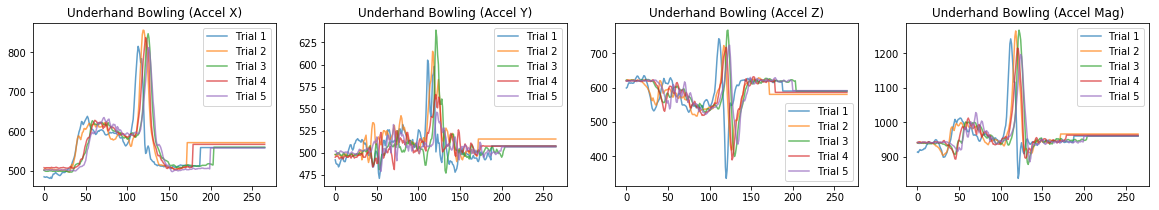

In [192]:
#Visualize raw input signals
plot_trials_data(mapGestureToTrials["Underhand Bowling"], "Underhand Bowling")

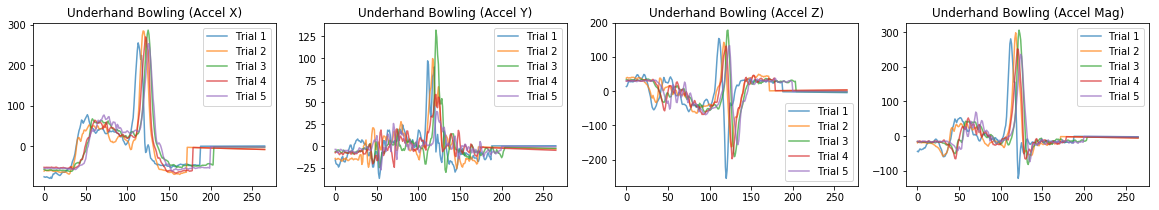

In [193]:
#Visualize detrending of signal
for gestureName, trialList in mapGestureToTrials.items():
        for trial in trialList: 
            trial.accel.detrend_axis()
            #x = 0
            
plot_trials_data(mapGestureToTrials["Underhand Bowling"], "Underhand Bowling")

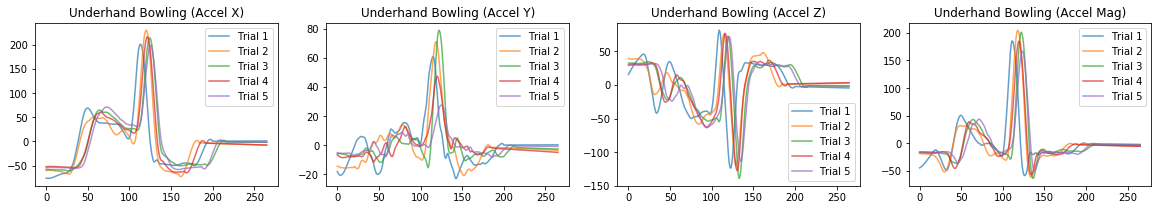

In [194]:
#Visualize smoothing of signal
for gestureName, trialList in mapGestureToTrials.items():
        for trial in trialList: 
            trial.accel.smooth_axis(25, 3)
            x = 0
            
plot_trials_data(mapGestureToTrials["Underhand Bowling"], "Underhand Bowling")

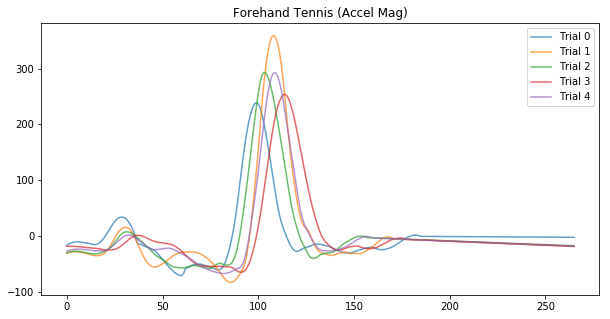

In [195]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


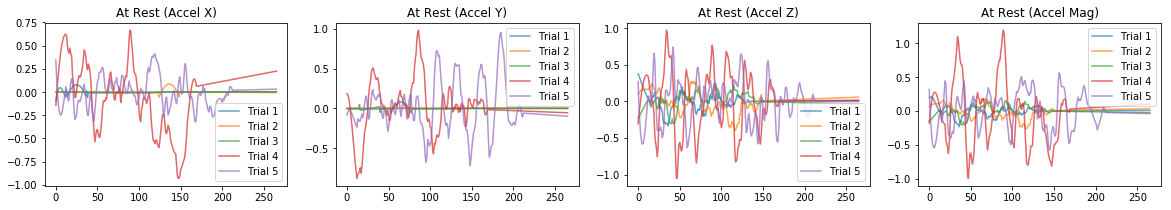

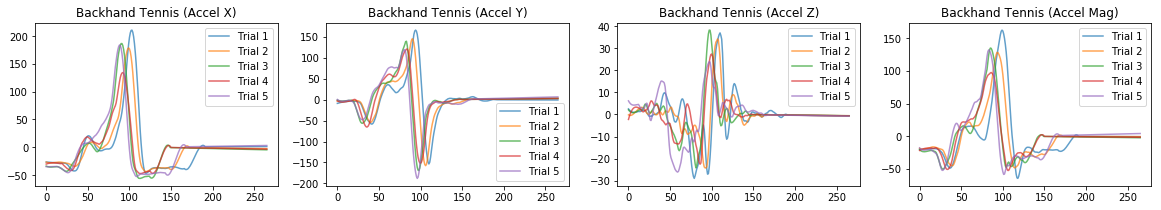

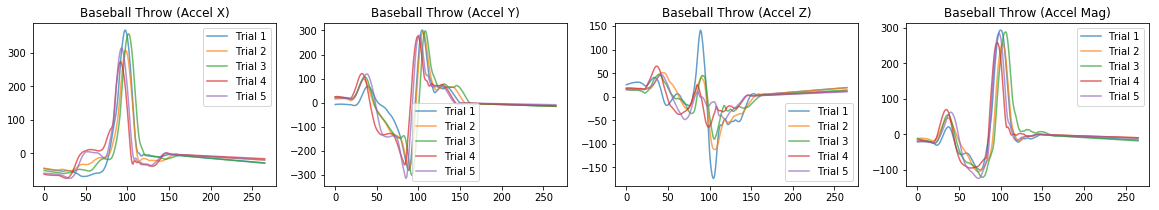

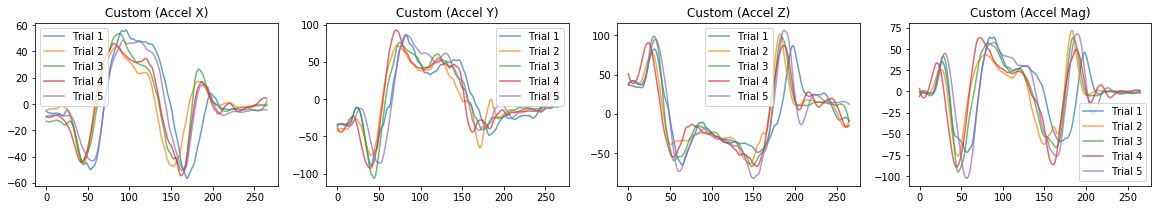

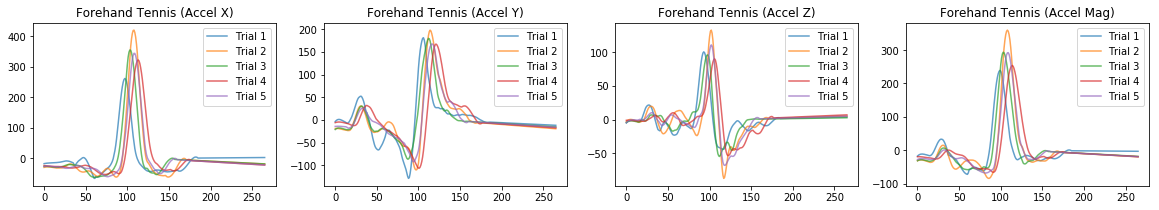

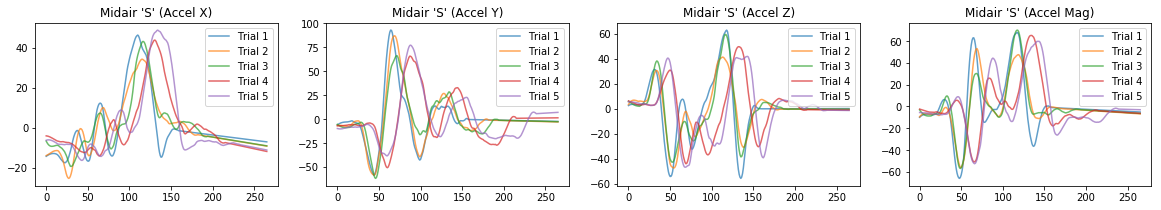

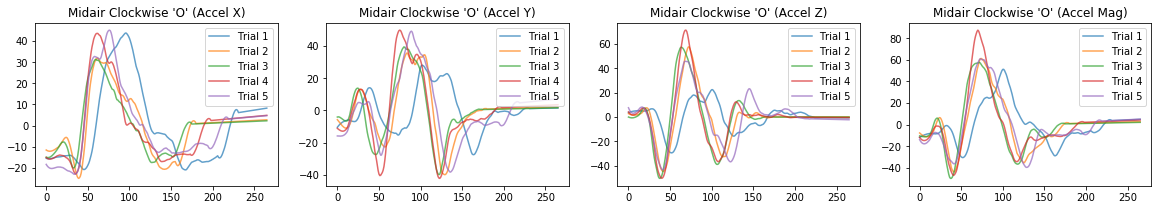

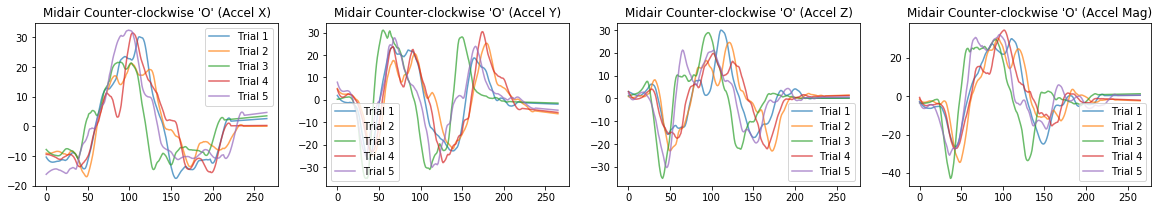

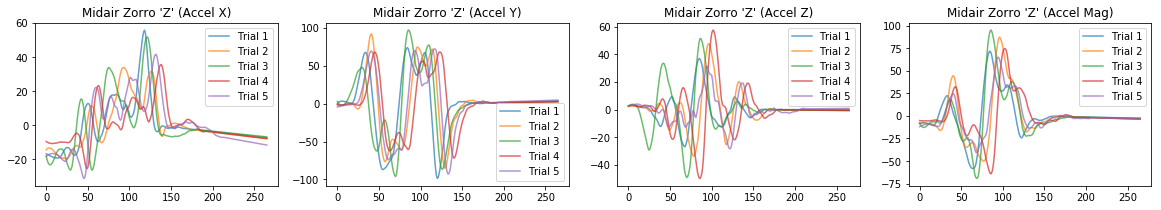

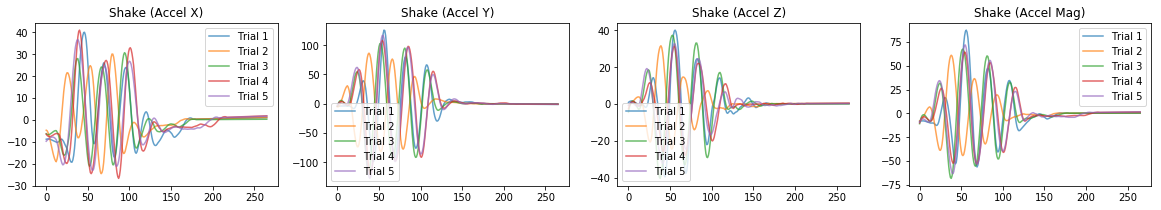

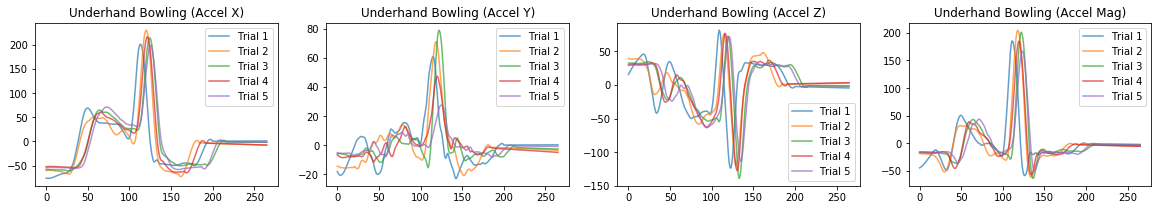

In [196]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    plot_trials_data(gestureTrials, gestureName)


# Generating k-folds by randomly assigning one trial of each gesture to each fold

In [197]:
#https://smallbusiness.chron.com/randomize-list-python-26724.html
import random
numFolds = 5
kfolds = [[] for i in range(numFolds)]
allTrials = []

gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    random.shuffle(gestureTrials)
    
    foldN = 0
    for trial in gestureTrials:
        kfolds[foldN].append(trial)
        foldN = foldN + 1

# Generating Templates
This cell generates templates for each gesture by averaging the trials of each gesture together. This process is made more complicated by the fact that the signals need to be aligned or else the templates will all be overly flat from not averaging the corresponding points. This is remedied by using dynamic time warping to figure out which data points in each signal match and then generating the templates using one trial as a base for comparison.

Fold 0 templates complete
Fold 1 templates complete
Fold 2 templates complete
Fold 3 templates complete


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Fold 4 templates complete
10.021118640899658


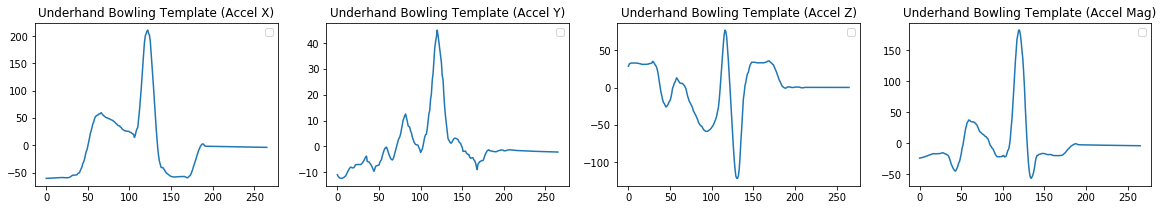

In [198]:
#construct templates from prepared data
import time
startTick = time.time() 
gestureTemplatesPerFold = [dict() for i in range(numFolds)]

for i in range(numFolds):
    gestureTemplates = dict()

    #initialize sensor data objects for each template of this fold
    gestureNamesSorted = sorted(mapGestureToTrials.keys())
    for gestureName in gestureNamesSorted:
        recLength = len(kfolds[0][0].accel.x)
        gestureTemplates[gestureName] = SensorData("template", kfolds[0][0].accel.currentTimeMs, kfolds[0][0].accel.sensorTimestampMs, np.zeros(recLength), np.zeros(recLength), np.zeros(recLength))
        
    baseCurvePicked = False
    baseCurves = dict()
    
    for j in range(numFolds):
        #make sure we're not using the test data for generating templates
        if j != i:
            for trial in kfolds[j]:
                if not baseCurvePicked:
                    baseCurves[trial.gestureName] = trial
                    #use the first trial as the base for the template
                    gestureTemplates[trial.gestureName].x = gestureTemplates[trial.gestureName].x + (trial.accel.x / (numFolds - 1))
                    gestureTemplates[trial.gestureName].y = gestureTemplates[trial.gestureName].y + (trial.accel.y / (numFolds - 1))
                    gestureTemplates[trial.gestureName].z = gestureTemplates[trial.gestureName].z + (trial.accel.z / (numFolds - 1))
                    gestureTemplates[trial.gestureName].mag = gestureTemplates[trial.gestureName].mag + (trial.accel.mag / (numFolds - 1)) 
                    
                else:
                    #get path pairs for each signal dimension
                    scoreX, pathX = fastdtw(baseCurves[trial.gestureName].accel.x, trial.accel.x)
                    scoreY, pathY = fastdtw(baseCurves[trial.gestureName].accel.y, trial.accel.y)
                    scoreZ, pathZ = fastdtw(baseCurves[trial.gestureName].accel.z, trial.accel.z)
                    scoreMag, pathMag = fastdtw(baseCurves[trial.gestureName].accel.mag, trial.accel.mag)
                    
                    #loop through each pair and add averaged values into template
                    #for instance a pair might be (10, 15) meaning the 10th point on our base signal
                    #matches the 15th on the compared signal so that point needs to be averaged and added to the 10th point
                    #multiple pairs may match the same point e.g (10, 15), (10, 16), (10, 17) so we only add the first occurrence
                    #to prevent our template curve from being inflated where many points match
                    firstIndMatchX = 0
                    for pairX in pathX:
                        if pairX[0] == firstIndMatchX:
                            gestureTemplates[trial.gestureName].x[firstIndMatchX] += (trial.accel.x[pairX[1]] / (numFolds - 1))
                            firstIndMatchX += 1
                            
                    firstIndMatchY = 0
                    for pairY in pathY:
                        if pairY[0] == firstIndMatchY:
                            gestureTemplates[trial.gestureName].y[firstIndMatchY] += (trial.accel.y[pairY[1]] / (numFolds - 1))
                            firstIndMatchY += 1
                            
                    firstIndMatchZ = 0
                    for pairZ in pathZ:
                        if pairZ[0] == firstIndMatchZ:
                            gestureTemplates[trial.gestureName].z[firstIndMatchZ] += (trial.accel.z[pairZ[1]] / (numFolds - 1))
                            firstIndMatchZ += 1
                            
                    firstIndMatchM = 0
                    for pairM in pathMag:
                        if pairM[0] == firstIndMatchM:
                            gestureTemplates[trial.gestureName].mag[firstIndMatchM] += (trial.accel.mag[pairM[1]] / (numFolds - 1))
                            firstIndMatchM += 1
    
            baseCurvePicked = True
    print("Fold " + str(i) + " templates complete")
    gestureTemplatesPerFold[i] = gestureTemplates
    
endTick = time.time()
print(endTick - startTick)
plot_sensor_data(gestureTemplatesPerFold[0]["Underhand Bowling"], "Underhand Bowling Template")

In [199]:
#cell for defining results file path data for saving
basePath = "./AlgorithmResultsMyData/"
confuseBasePath = "./AlgorithmConfusionMyData/"
algorithmType = "DetrendSmooth25_"

# Comparing each fold against all other folds
This cell does the simple approach of iterating through each fold and comparing the gestures against all the gestures in every other fold. As a scoring function I am adding the differences in x, y, and z signals between the pairs of trials. While I have found the most consistent success with this approach it also takes extremely long for obvious reasons. As I generate these results I also store relevant data in a variety of arrays to then be written to files in the next cell.

In [200]:
from scipy.spatial.distance import euclidean
from scipy.spatial import distance
from fastdtw import fastdtw
import time
startTick = time.time()
resAllMatch = "All.out"

foldNum = []
foldCorrect = []
foldTotal = []
foldAcc = []
true = []
pred = []

for i in range(numFolds):
    testFold = kfolds[i]
    correct = 0
    total = 0
    for testTrial in testFold:
        #initialize our best score to be as high as possible
        bestScore = float("inf")
        bestTrial = testTrial
        for j in range(numFolds):
            #don't check against the current fold
            if i != j:
                for trainTrial in kfolds[j]:
                    #actual score calculation for comparison
                    currScoreX, path = fastdtw(trainTrial.accel.x, testTrial.accel.x)
                    currScoreY, path = fastdtw(trainTrial.accel.y, testTrial.accel.y)
                    currScoreZ, path = fastdtw(trainTrial.accel.z, testTrial.accel.z)
                    currScore = currScoreX + currScoreY + currScoreZ
                    if currScore < bestScore:
                        bestScore = currScore
                        bestTrial = trainTrial
                        
        total = total + 1
        
        pred.append(bestTrial.gestureName)
        true.append(testTrial.gestureName)
        
        if bestTrial.gestureName == testTrial.gestureName:
            correct = correct + 1
        else:
            print("\nIncorrect: ")
            print("Estimate: " + bestTrial.gestureName)
            print("Actual: " + testTrial.gestureName)
    foldNum.append(i + 1)
    foldCorrect.append(correct)
    foldTotal.append(total)
    foldAcc.append(correct / total)
    
    print("\nIteration: " + str(i + 1))
    print("Correct: " + str(correct))
    print("Total: " + str(total))
    print("Accuracy: " + str(correct / total))

endTick = time.time()
print(endTick - startTick)


Iteration: 1
Correct: 11
Total: 11
Accuracy: 1.0

Incorrect: 
Estimate: Midair Counter-clockwise 'O'
Actual: Midair Clockwise 'O'

Iteration: 2
Correct: 10
Total: 11
Accuracy: 0.9090909090909091

Iteration: 3
Correct: 11
Total: 11
Accuracy: 1.0

Iteration: 4
Correct: 11
Total: 11
Accuracy: 1.0

Iteration: 5
Correct: 11
Total: 11
Accuracy: 1.0
141.9733395576477


In [201]:
# These sources were used for figuring out how to store multiple arrays and strings into text files
# that could later be read back in with little hassle in processing the data
#https://stackoverflow.com/questions/16621351/how-to-use-python-numpy-savetxt-to-write-strings-and-float-number-to-an-ascii-fi
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html
saveResPath = basePath + algorithmType + resAllMatch
saveConfusePath = confuseBasePath + algorithmType + resAllMatch

np.savetxt(saveResPath, (foldNum, foldCorrect, foldTotal, foldAcc), delimiter=", ")
np.savetxt(saveConfusePath, (true, pred), fmt='%.30s', delimiter=", ")

# Comparing each fold against the corresponding templates
This cell takes the more complex approach of comparing each fold against the respective set of templates that have been generated in order to prevent cross-over of test and training data. This version uses the same scoring function in order to maintain a good comparison between template and all signal matching. Like the previous section a variety of arrays are constructed for storing relevant data from the results that gets written to text files in the subsequent cell.

In [202]:
resTemplateMatch = "Template.out"

from scipy.spatial.distance import euclidean
from scipy.spatial import distance
from fastdtw import fastdtw
import time
startTick = time.time()


foldNum = []
foldCorrect = []
foldTotal = []
foldAcc = []
true = []
pred = []

for i in range(numFolds):
    testFold = kfolds[i]
    correct = 0
    total = 0
    # get the set of templates for this fold
    gestureTemplates = gestureTemplatesPerFold[i]
    for testTrial in testFold:
        bestScore = float("inf")
        bestTrial = testTrial.gestureName
        
        for g in gestureTemplates:
            currScoreX, path = fastdtw(testTrial.accel.x, gestureTemplates[g].x)
            currScoreY, path = fastdtw(testTrial.accel.y, gestureTemplates[g].y)
            currScoreZ, path = fastdtw(testTrial.accel.z, gestureTemplates[g].z)
            #currScoreMag, path = fastdtw(testTrial.accel.mag, gestureTemplates[g].mag)
            currScore = currScoreX + currScoreY + currScoreZ
            if currScore < bestScore:
                bestScore = currScore
                bestTrial = g
                        
        total = total + 1
        
        pred.append(bestTrial)
        true.append(testTrial.gestureName)
        
        if bestTrial == testTrial.gestureName:
            correct = correct + 1
        else:
            print("\nIncorrect: ")
            print("Estimate: " + bestTrial)
            print("Actual: " + testTrial.gestureName)
            
    foldNum.append(i + 1)
    foldCorrect.append(correct)
    foldTotal.append(total)
    foldAcc.append(correct / total)
    
    print("\nIteration: " + str(i + 1))
    print("Correct: " + str(correct))
    print("Total: " + str(total))
    print("Accuracy: " + str(correct / total))

endTick = time.time()
print(endTick - startTick)


Iteration: 1
Correct: 11
Total: 11
Accuracy: 1.0

Iteration: 2
Correct: 11
Total: 11
Accuracy: 1.0

Iteration: 3
Correct: 11
Total: 11
Accuracy: 1.0

Iteration: 4
Correct: 11
Total: 11
Accuracy: 1.0

Iteration: 5
Correct: 11
Total: 11
Accuracy: 1.0
35.591657876968384


In [203]:
# These sources were used for figuring out how to store multiple arrays and strings into text files
# that could later be read back in with little hassle in processing the data
#https://stackoverflow.com/questions/16621351/how-to-use-python-numpy-savetxt-to-write-strings-and-float-number-to-an-ascii-fi
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.savetxt.html
saveResPath = basePath + algorithmType + resTemplateMatch
saveConfusePath = confuseBasePath + algorithmType + resTemplateMatch

np.savetxt(saveResPath, (foldNum, foldCorrect, foldTotal, foldAcc), delimiter=", ")
np.savetxt(saveConfusePath, (true, pred), fmt='%.30s', delimiter=", ")

# Straight comparisons
This block was the first way I tested comparing signals to each other and I left it in as a general gauge on how my current signal processing was doing

In [204]:

from scipy.spatial.distance import euclidean
from scipy.spatial import distance
from fastdtw import fastdtw

correct = 0
total = 0
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    for trial in gestureTrials:
        
        bestGesture = gestureName
        bestGestureScore, path = fastdtw(trial.accel.mag, gestureTemplates[gestureName].mag, dist=euclidean)
        for templateName in gestureNamesSorted:
            currScore, bestPath = fastdtw(trial.accel.mag, gestureTemplates[templateName].mag)
            if currScore < bestGestureScore:
                bestGestureScore = currScore
                bestGesture = templateName
        total = total + 1
        if bestGesture == gestureName:
            correct = correct + 1
        else:
            print(bestGesture)
            print(gestureName)
    
print(correct)
print(total)

55
55


In [205]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualizing all the Results
These cells iterate through all the different folders of results I have stored and generate charts for the raw results, per gesture accuracy and confusion matrices of every experiment I have run

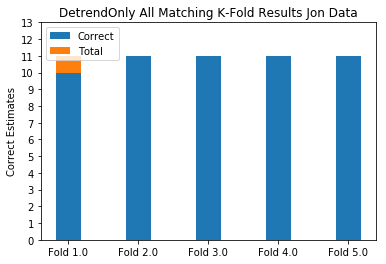

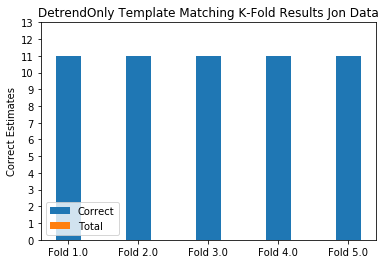

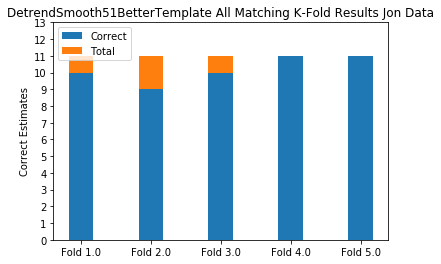

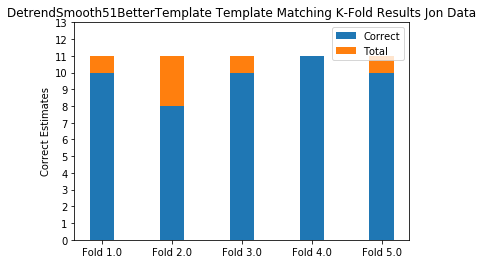

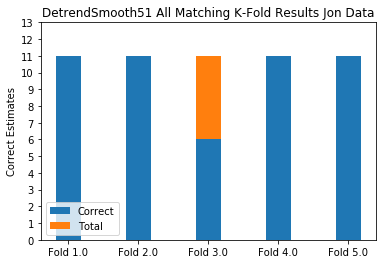

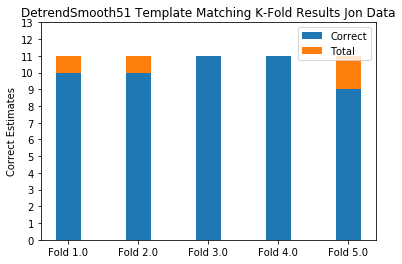

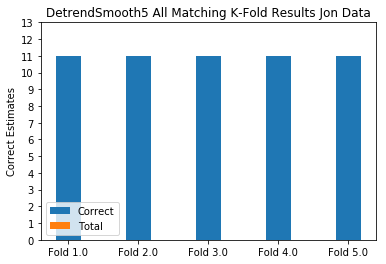

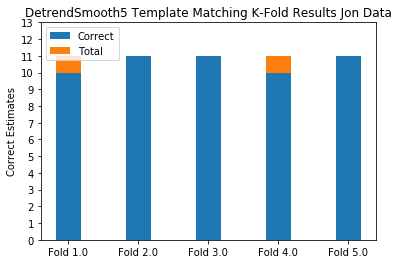

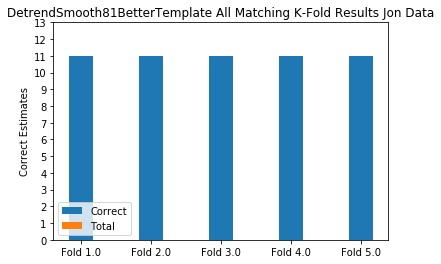

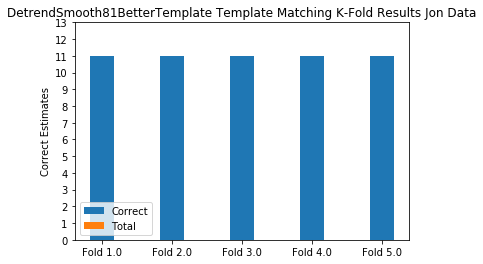

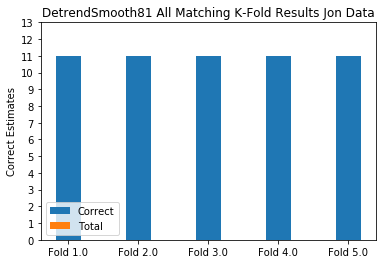

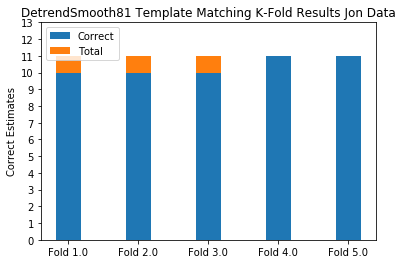

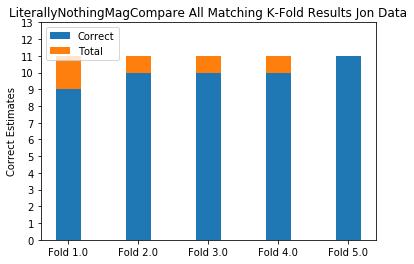

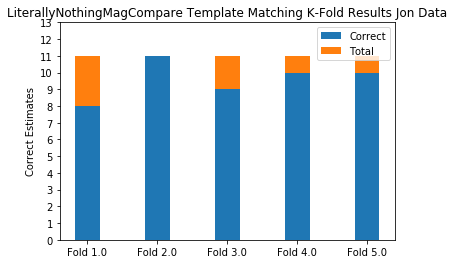

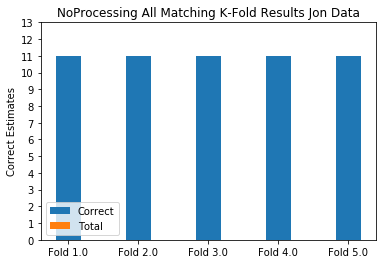

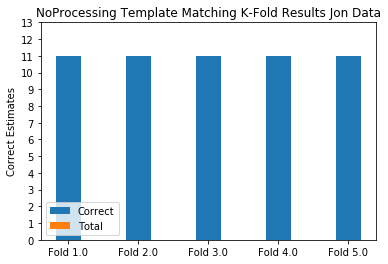

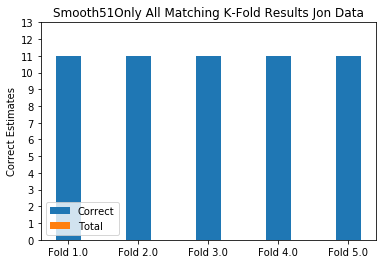

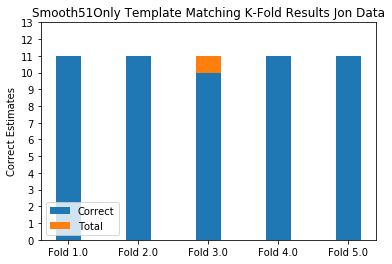

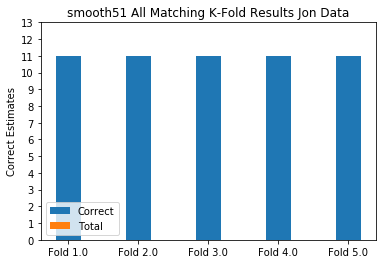

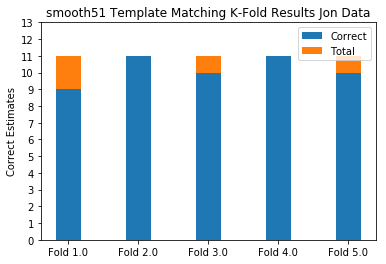

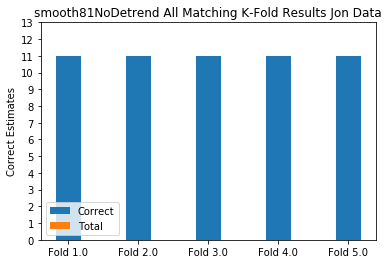

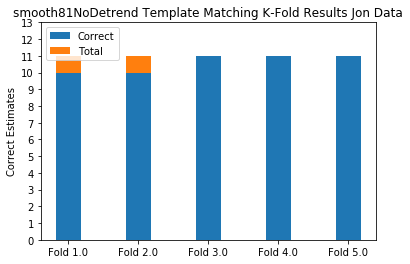

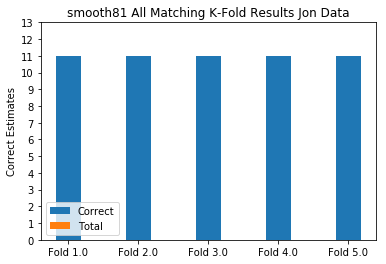

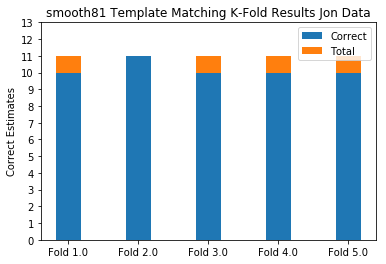

<Figure size 432x288 with 0 Axes>

In [206]:
#https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py
from os import listdir
import os
import matplotlib.pyplot as plt
#plot results
jonDataRes = "./AlgorithmResultsJonData"
resFiles = listdir(jonDataRes)

for resFile in resFiles:
    fileNoExt = os.path.splitext(resFile)[0]
    resInfo = fileNoExt.split("_")
    resTrial, resCorrect, resTotal, resAcc = np.loadtxt(jonDataRes +  "/" + resFile, delimiter=", ")
    resPltCorrect = plt.bar(resTrial, resCorrect, 0.35)
    resPltTotal = plt.bar(resTrial, resTotal - resCorrect, 0.35, bottom=resCorrect)
    
    plt.ylabel("Correct Estimates")
    plt.title(resInfo[0] + " " + resInfo[1] + " Matching K-Fold Results Jon Data")
    plt.xticks(resTrial, ["Fold " + str(i) for i in resTrial])
    plt.yticks(np.arange(0, resTotal[0] + 3, 1))
    plt.legend((resPltCorrect[0], resPltTotal[0]), ("Correct", "Total"))
    
    plt.figure()
plt.show()

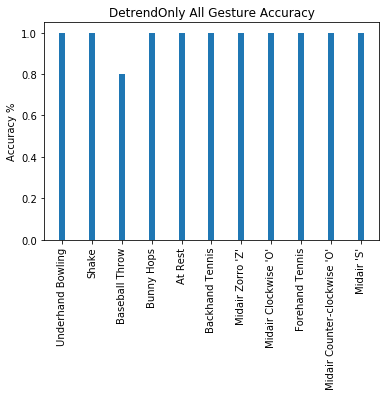

Confusion matrix, without normalization


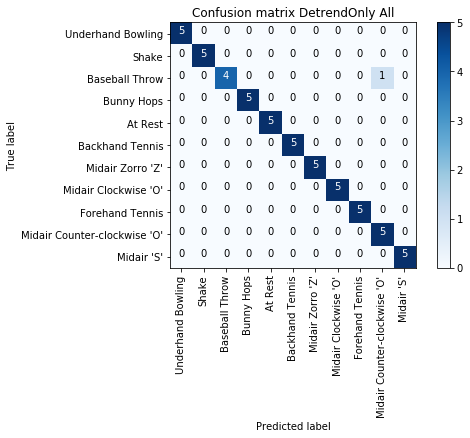

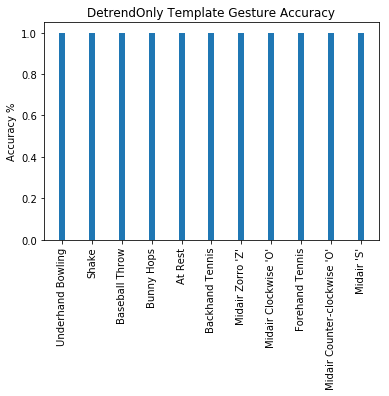

Confusion matrix, without normalization


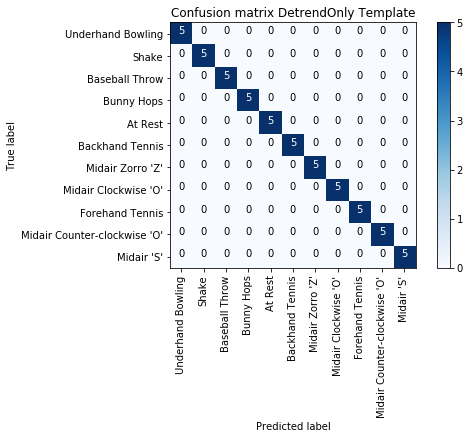

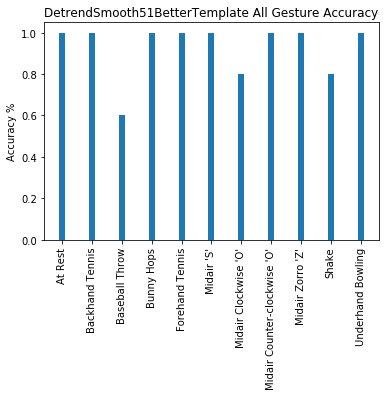

Confusion matrix, without normalization


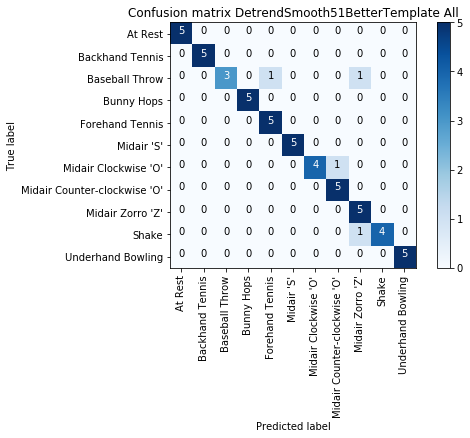

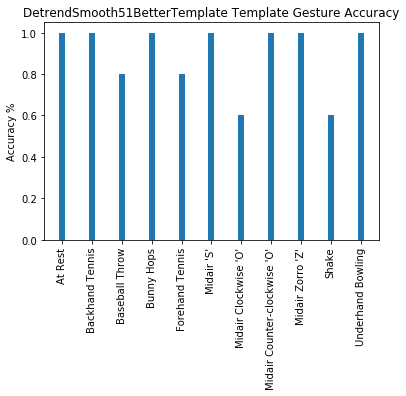

Confusion matrix, without normalization


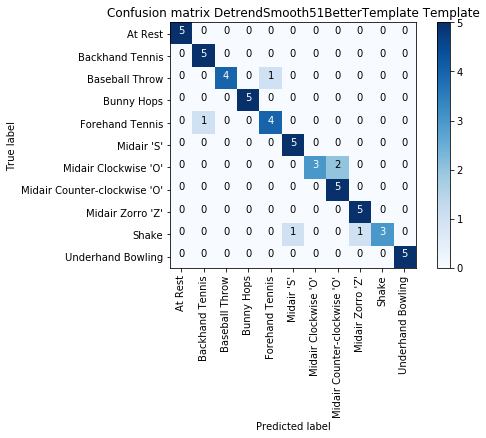

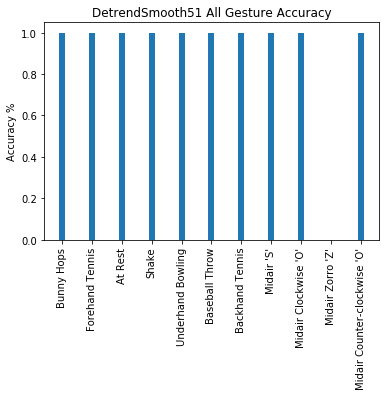

Confusion matrix, without normalization


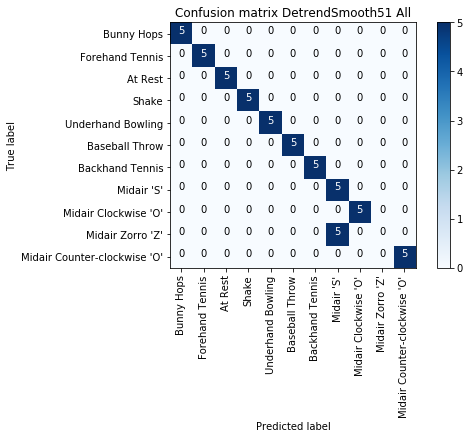

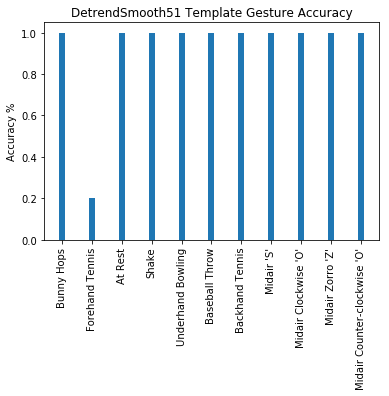

Confusion matrix, without normalization


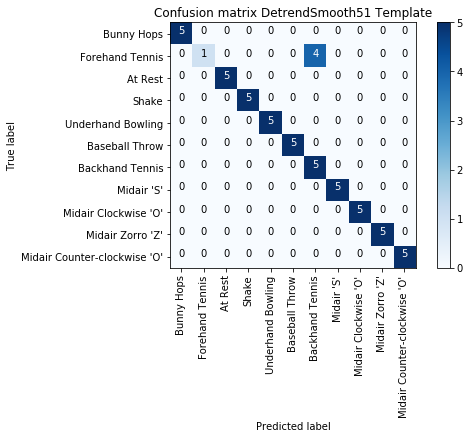

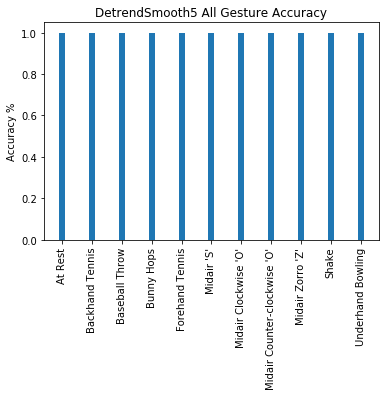

Confusion matrix, without normalization


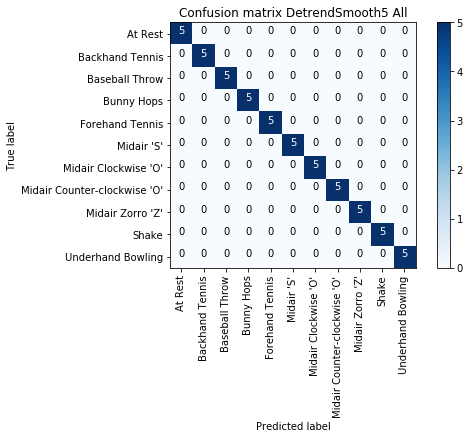

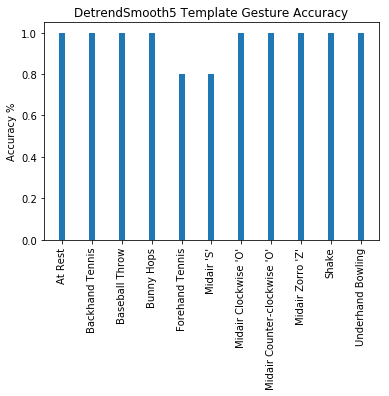

Confusion matrix, without normalization


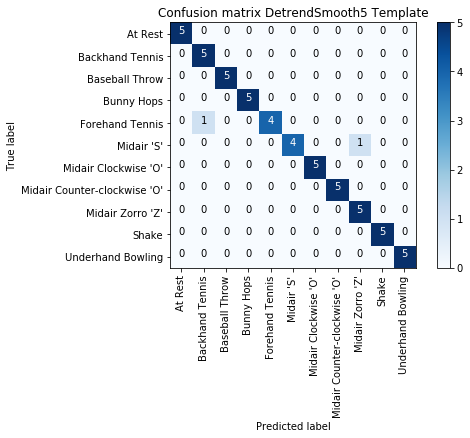

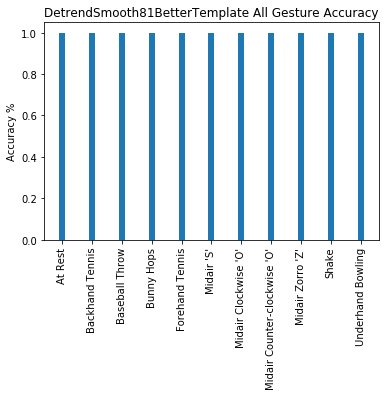

Confusion matrix, without normalization


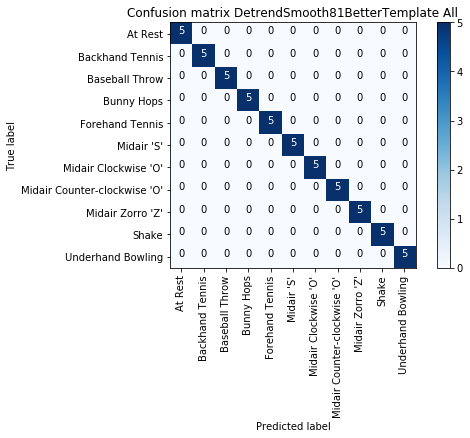

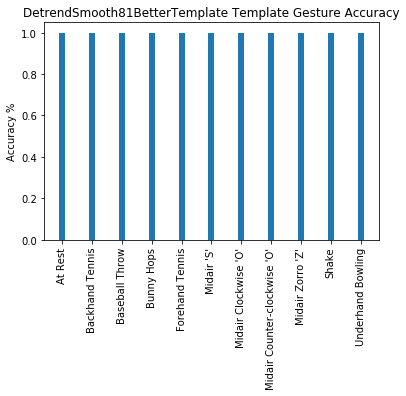

Confusion matrix, without normalization


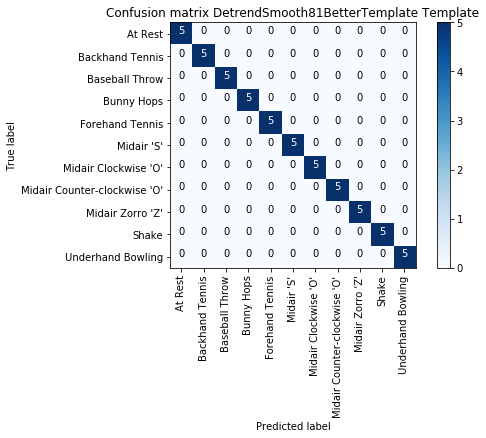

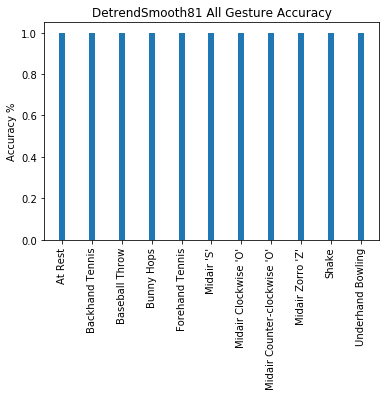

Confusion matrix, without normalization


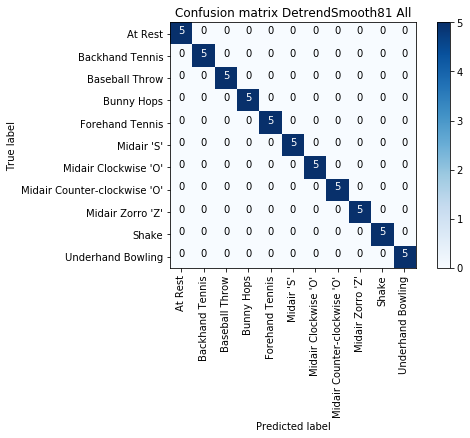

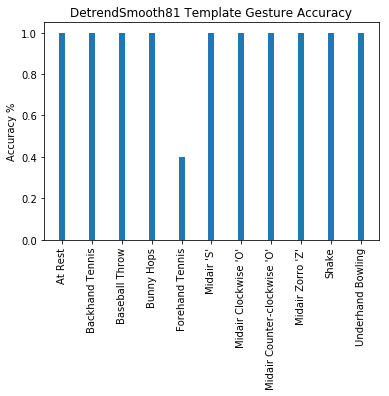

Confusion matrix, without normalization


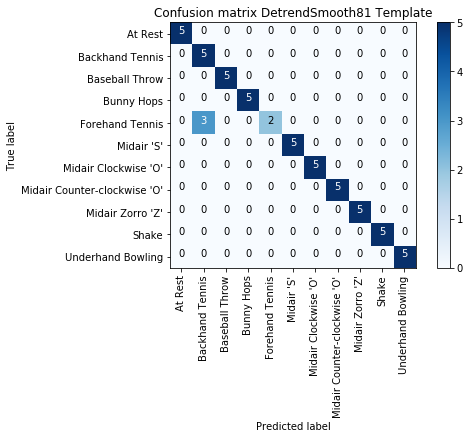

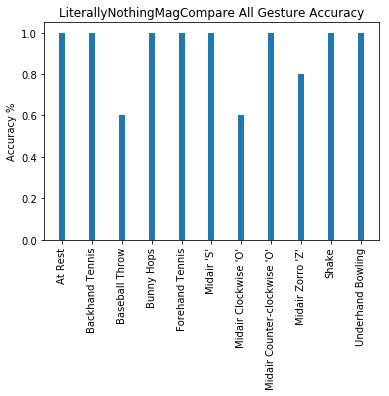

Confusion matrix, without normalization


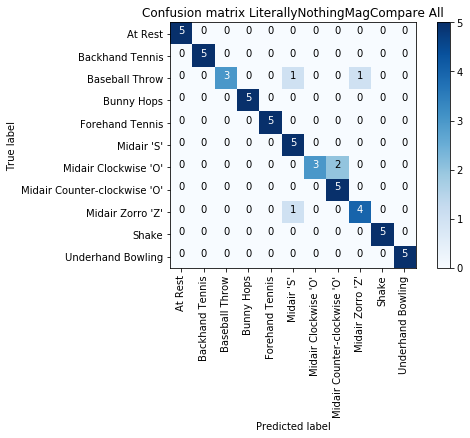

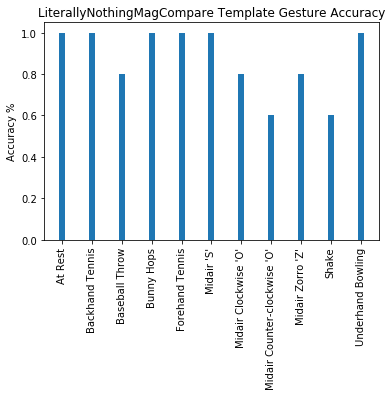

Confusion matrix, without normalization


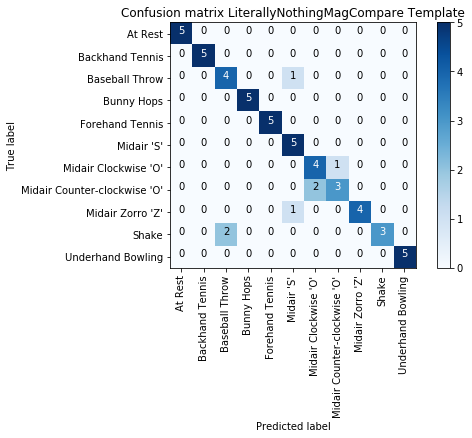

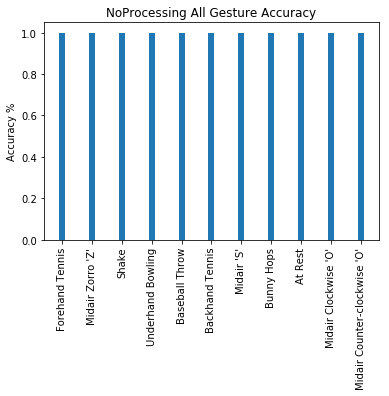

Confusion matrix, without normalization


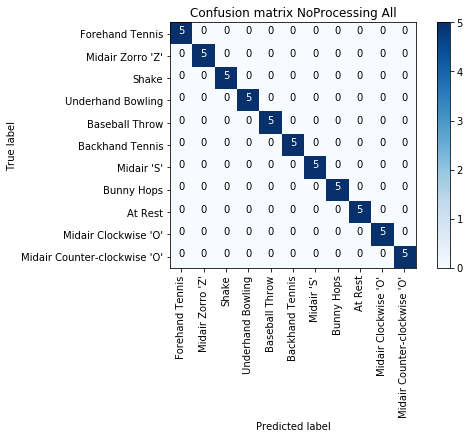

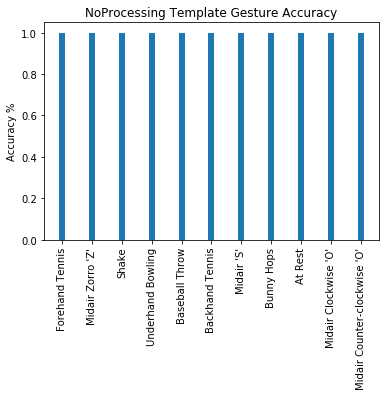

Confusion matrix, without normalization


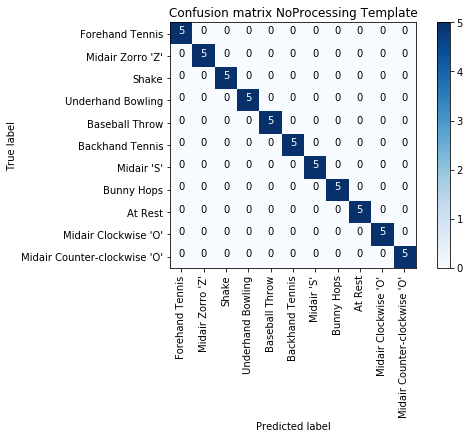

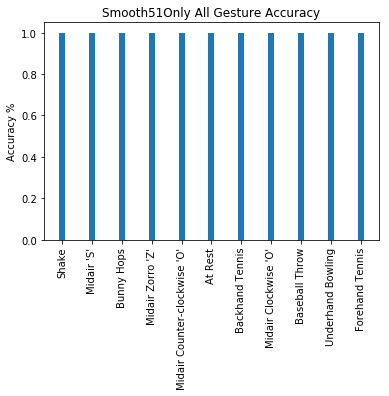

Confusion matrix, without normalization


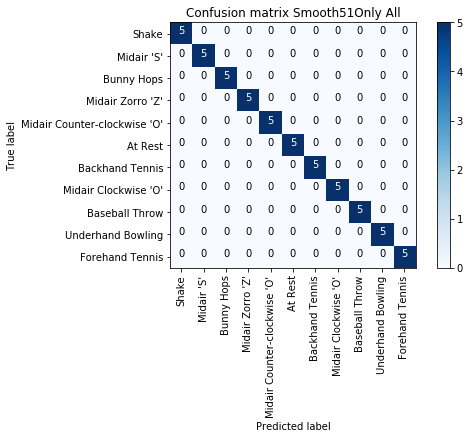

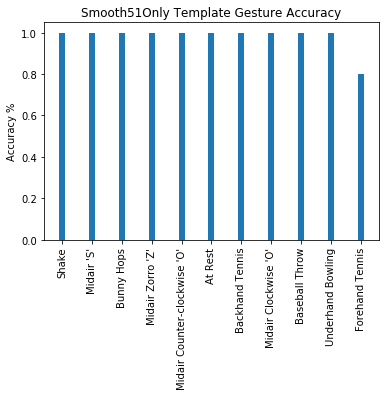

Confusion matrix, without normalization


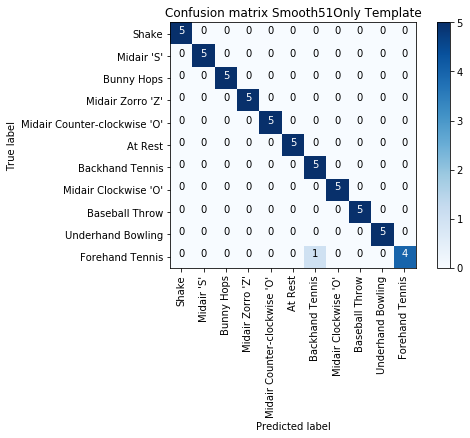

In [207]:
jonDataConfuse = "./AlgorithmConfusionJonData"
confFiles = listdir(jonDataConfuse)

for confFile in confFiles:
    fileNoExt = os.path.splitext(confFile)[0]
    confInfo = fileNoExt.split("_")
    correctMap = dict()
    true, pred = np.loadtxt(jonDataConfuse +  "/" + confFile, dtype='U30', delimiter=", ")
    labels = []
    #set up labels for charts
    for gestureName in true:
        if not gestureName in labels:
            labels.append(gestureName)
            correctMap[gestureName] = 0
    
    #calculate accuracy from true/pred pairs
    for i in range(len(true)):
        if true[i] == pred[i]:
            correctMap[true[i]] += 1
    
    #get percentage accuracy from raw correct/total
    for gesture in correctMap:
        correctMap[gesture] /= len(true) / len(labels)
        
    # source for how to easily convert a dictionary to a bar chart
    #https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
    resPltAcc = plt.bar(range(len(correctMap)), list(correctMap.values()), .2)
    plt.ylabel("Accuracy %")
    plt.title(confInfo[0] + " " + confInfo[1] + " Gesture Accuracy")
    plt.xticks(range(len(correctMap)), list(correctMap.keys()), rotation="vertical")
    plt.show()
            
    #generate confusion matrix
    cm = confusion_matrix(true, pred, labels)
    plt.figure(figsize=(8,6))
    plot_confusion_matrix(cm, classes=labels, title='Confusion matrix ' + confInfo[0] + " " + confInfo[1])
    plt.show()

DetrendOnly
All
[1. 2. 3. 4. 5.]


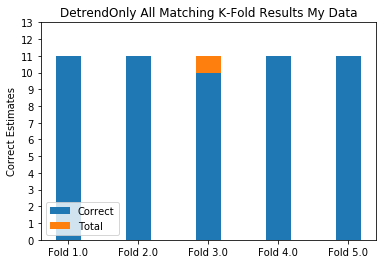

DetrendOnly
Template
[1. 2. 3. 4. 5.]


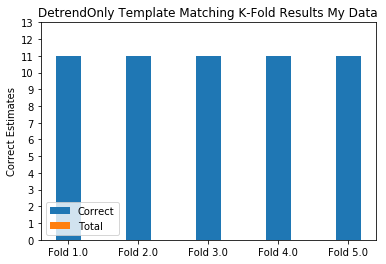

DetrendSmooth25
All
[1. 2. 3. 4. 5.]


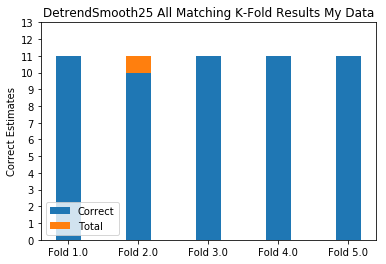

DetrendSmooth25
Template
[1. 2. 3. 4. 5.]


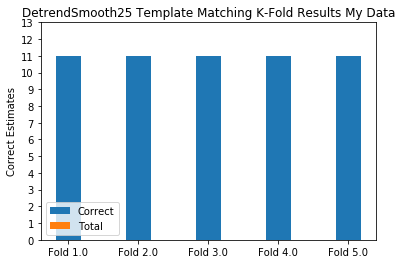

DetrendSmooth51
All
[1. 2. 3. 4. 5.]


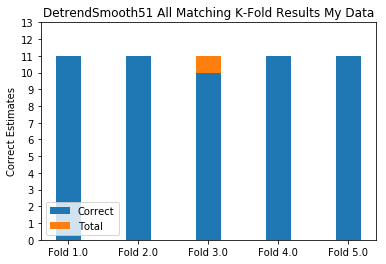

DetrendSmooth51
Template
[1. 2. 3. 4. 5.]


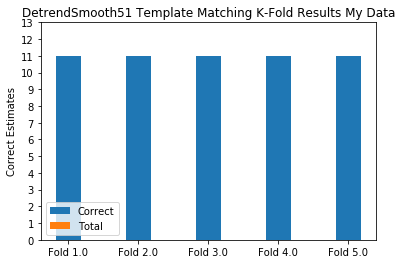

DetrendSmooth81Mag
All
[1. 2. 3. 4. 5.]


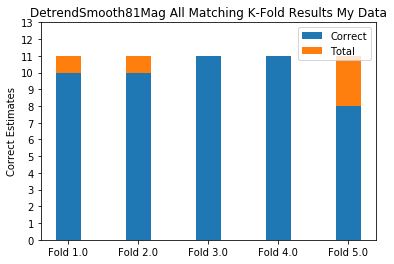

DetrendSmooth81Mag
Template
[1. 2. 3. 4. 5.]


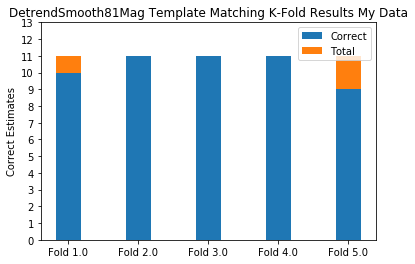

DetrendSmooth81
All
[1. 2. 3. 4. 5.]


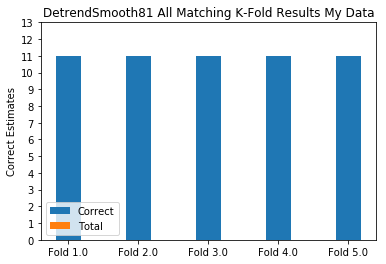

DetrendSmooth81
Template
[1. 2. 3. 4. 5.]


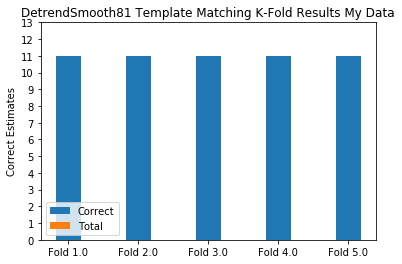

LiterallyNothingMagCompare
All
[1. 2. 3. 4. 5.]


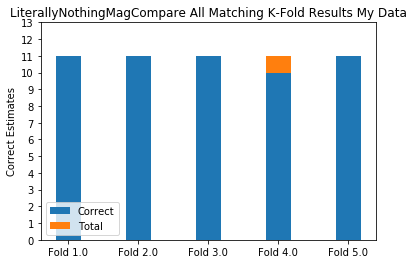

LiterallyNothingMagCompare
Template
[1. 2. 3. 4. 5.]


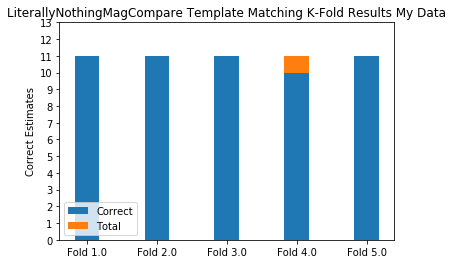

NoProcessing
All
[1. 2. 3. 4. 5.]


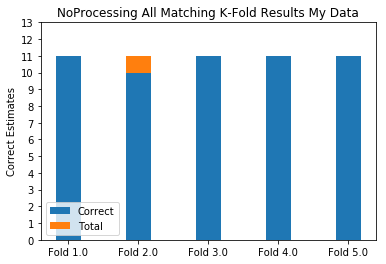

NoProcessing
Template
[1. 2. 3. 4. 5.]


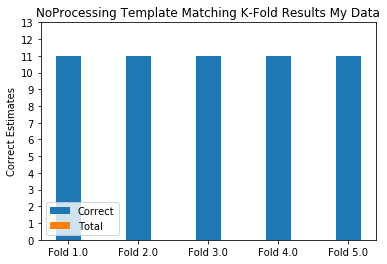

Smooth51Only
All
[1. 2. 3. 4. 5.]


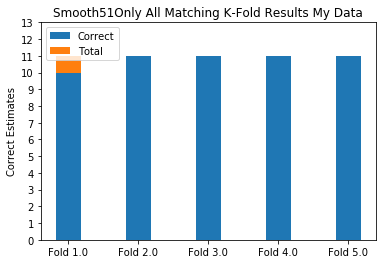

Smooth51Only
Template
[1. 2. 3. 4. 5.]


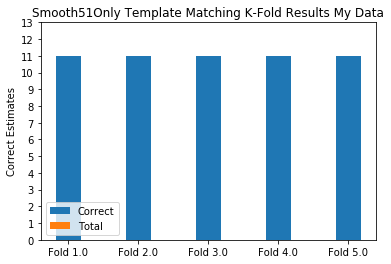

smooth51
All
[1. 2. 3. 4. 5.]


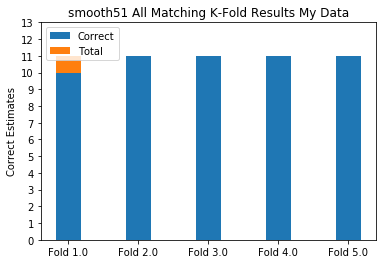

smooth51
Template
[1. 2. 3. 4. 5.]


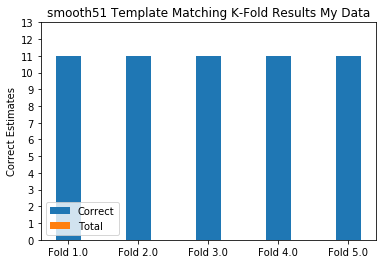

smooth81NoDetrend
All
[1. 2. 3. 4. 5.]


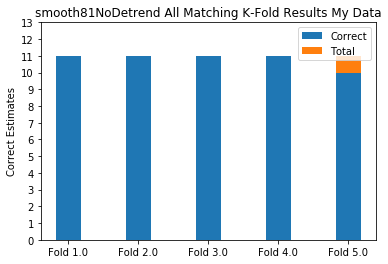

smooth81NoDetrend
Template
[1. 2. 3. 4. 5.]


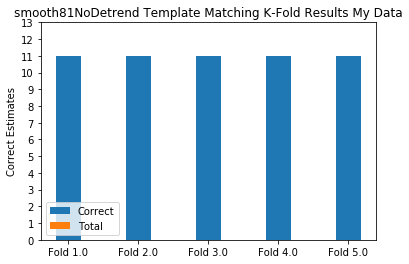

smooth81
All
[1. 2. 3. 4. 5.]


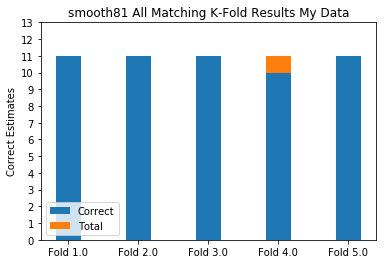

smooth81
Template
[1. 2. 3. 4. 5.]


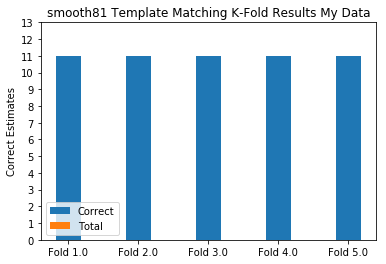

In [208]:
from os import listdir
import os
import matplotlib.pyplot as plt
#plot results
myDataRes = "./AlgorithmResultsMyData"
myresFiles = listdir(myDataRes)

for resFile in myresFiles:
    fileNoExt = os.path.splitext(resFile)[0]
    resInfo = fileNoExt.split("_")
    print(resInfo[0])
    print(resInfo[1])
    resTrial, resCorrect, resTotal, resAcc = np.loadtxt(myDataRes +  "/" + resFile, delimiter=", ")
    print(resTrial)
    resPltCorrect = plt.bar(resTrial, resCorrect, 0.35)
    resPltTotal = plt.bar(resTrial, resTotal - resCorrect, 0.35, bottom=resCorrect)
    
    plt.ylabel("Correct Estimates")
    plt.title(resInfo[0] + " " + resInfo[1] + " Matching K-Fold Results My Data")
    plt.xticks(resTrial, ["Fold " + str(i) for i in resTrial])
    plt.yticks(np.arange(0, resTotal[0] + 3, 1))
    plt.legend((resPltCorrect[0], resPltTotal[0]), ("Correct", "Total"))
    
    plt.show()

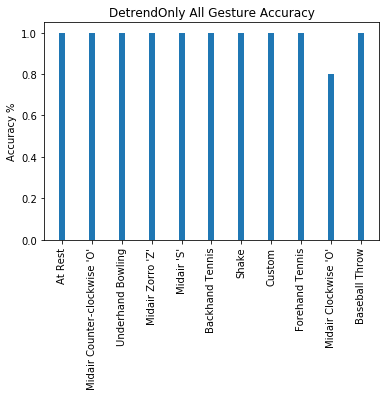

Confusion matrix, without normalization


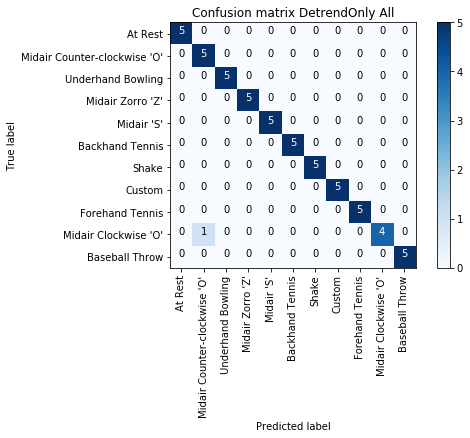

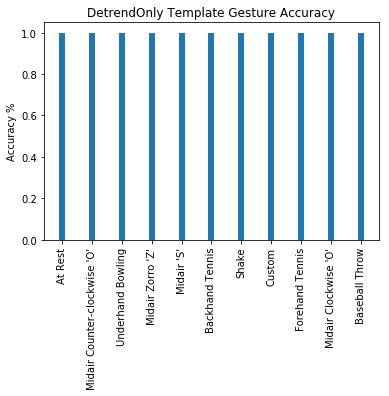

Confusion matrix, without normalization


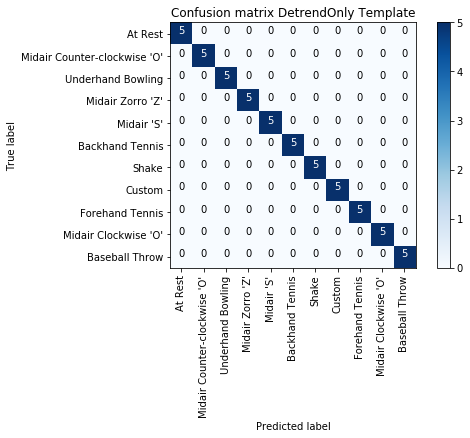

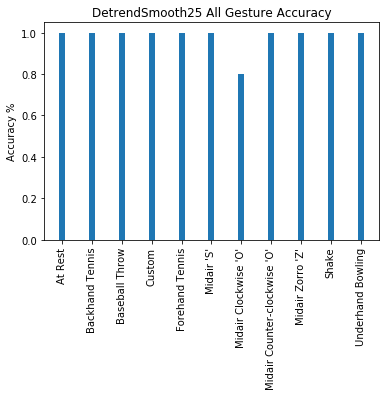

Confusion matrix, without normalization


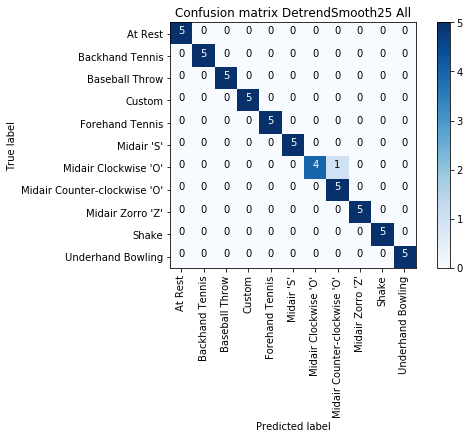

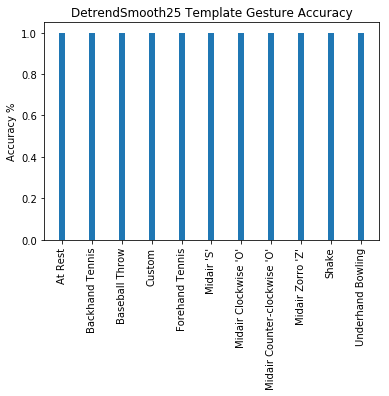

Confusion matrix, without normalization


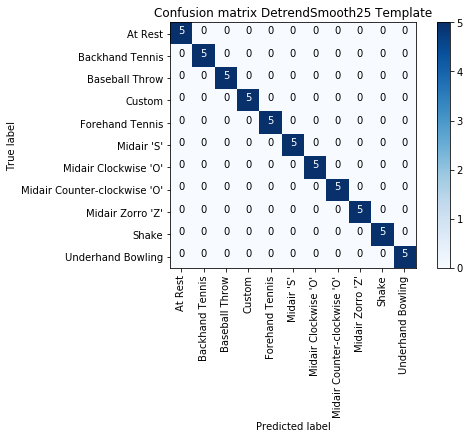

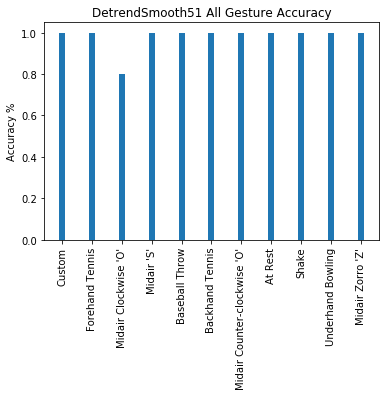

Confusion matrix, without normalization


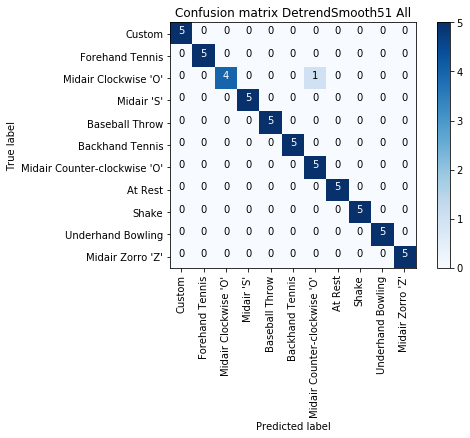

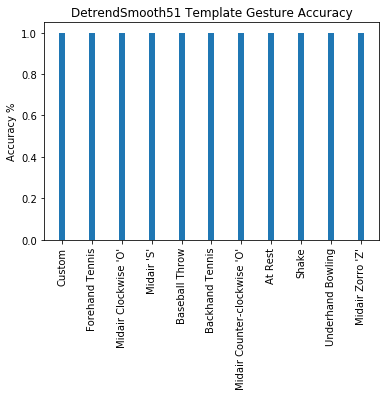

Confusion matrix, without normalization


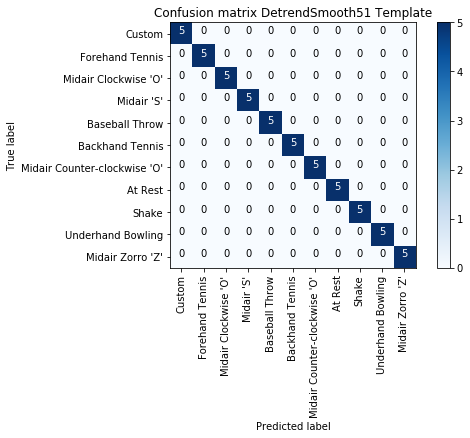

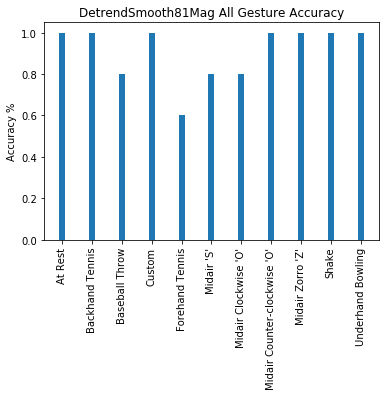

Confusion matrix, without normalization


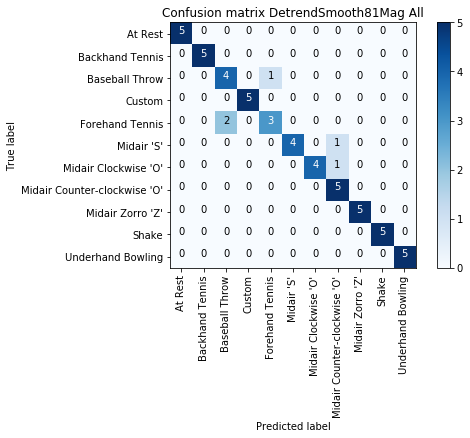

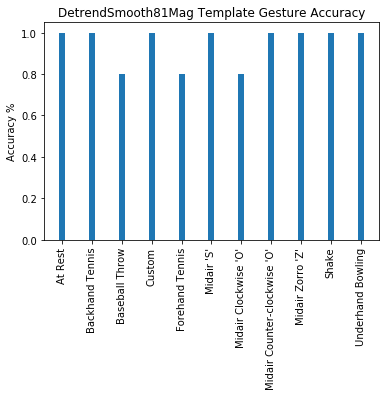

Confusion matrix, without normalization


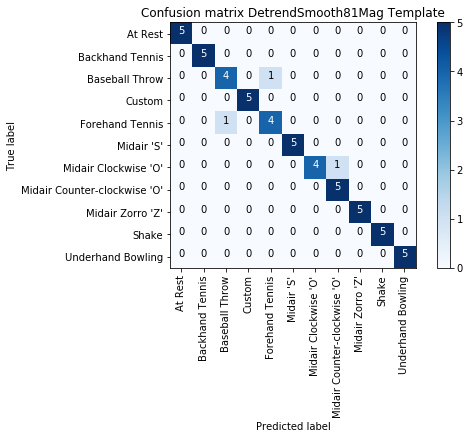

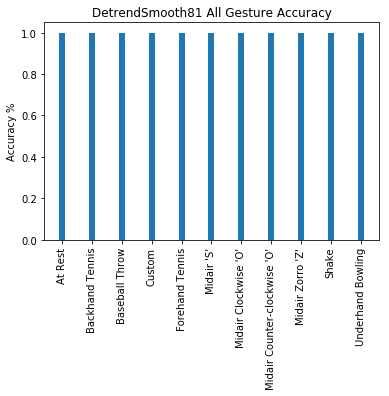

Confusion matrix, without normalization


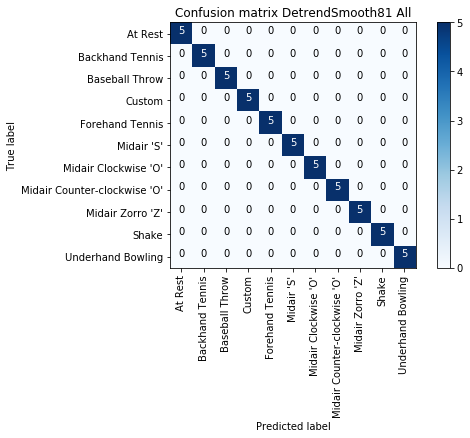

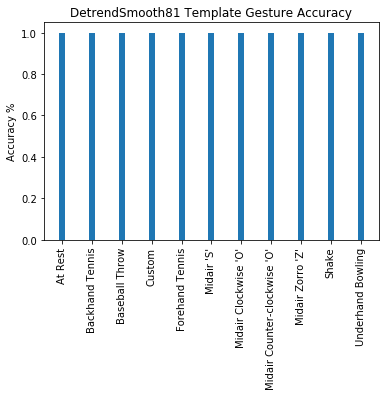

Confusion matrix, without normalization


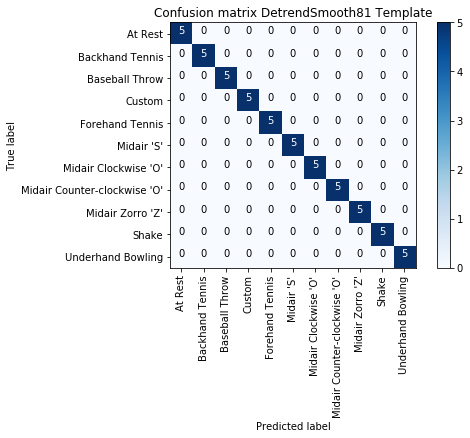

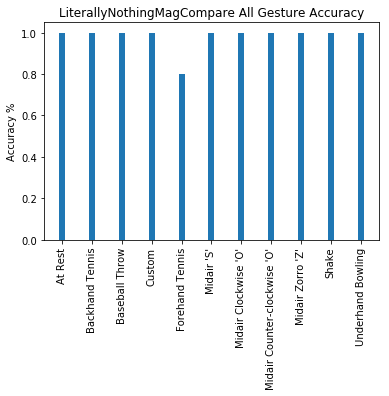

Confusion matrix, without normalization


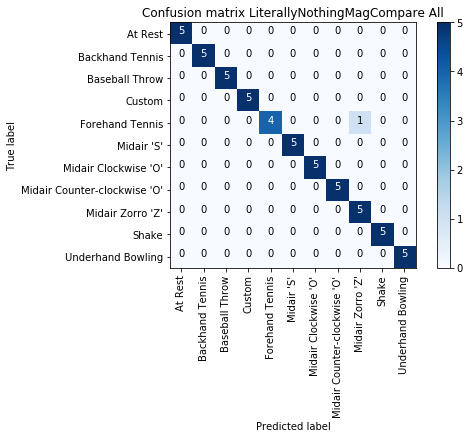

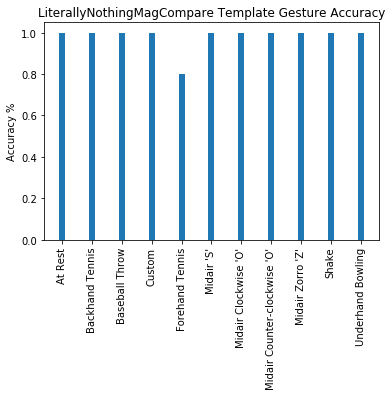

Confusion matrix, without normalization


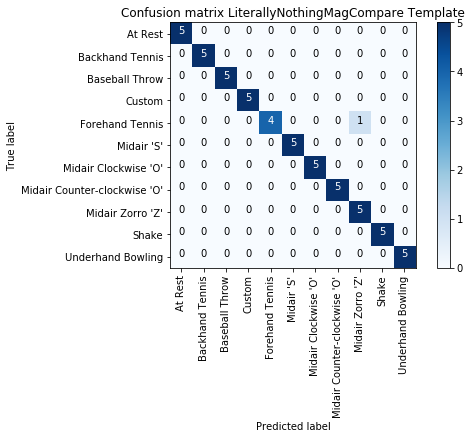

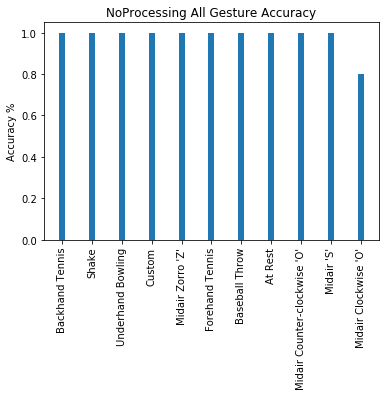

Confusion matrix, without normalization


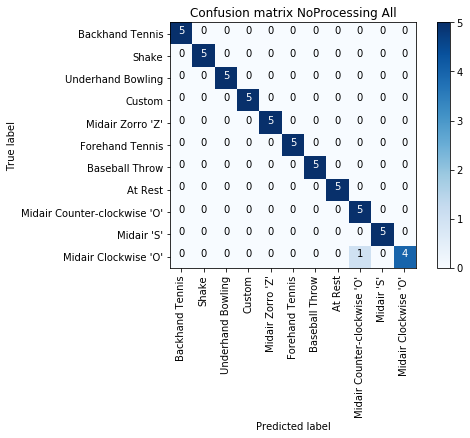

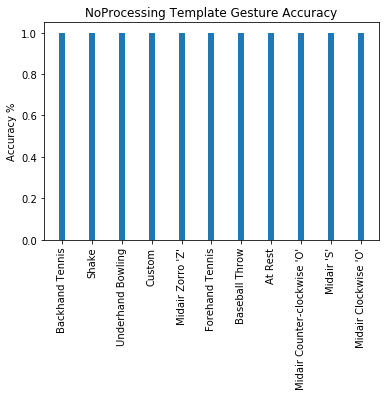

Confusion matrix, without normalization


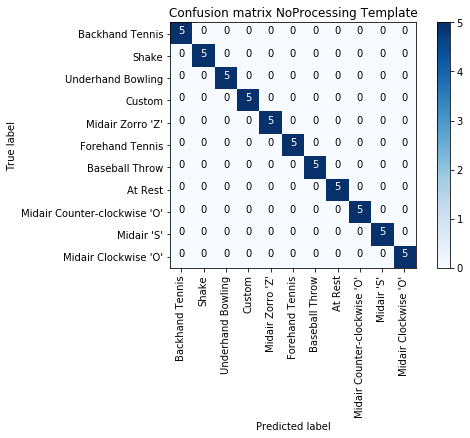

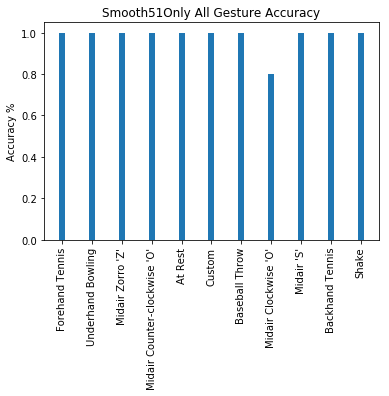

Confusion matrix, without normalization


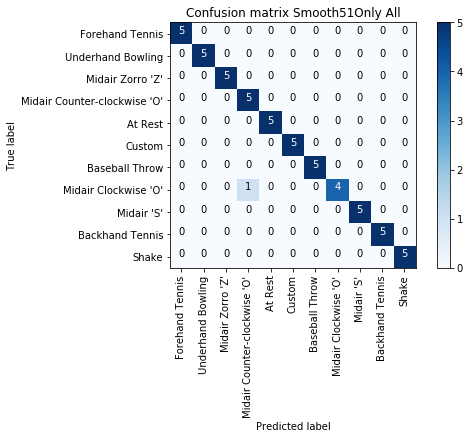

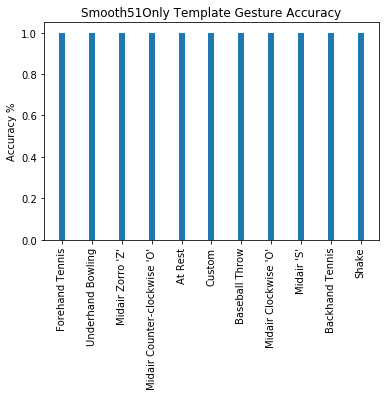

Confusion matrix, without normalization


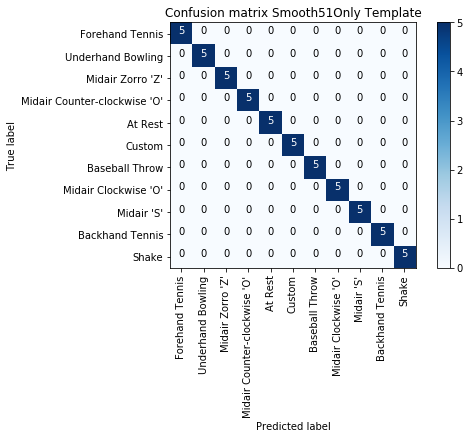

In [209]:
#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html
myDataConfuse = "./AlgorithmConfusionMyData"
confFiles = listdir(myDataConfuse)

for confFile in confFiles:
    fileNoExt = os.path.splitext(confFile)[0]
    confInfo = fileNoExt.split("_")
    correctMap = dict()
    true, pred = np.loadtxt(myDataConfuse +  "/" + confFile, dtype='U30', delimiter=", ")
    labels = []
    for gestureName in true:
        if not gestureName in labels:
            labels.append(gestureName)
            correctMap[gestureName] = 0
            
    for i in range(len(true)):
        if true[i] == pred[i]:
            correctMap[true[i]] += 1
            
    for gesture in correctMap:
        correctMap[gesture] /= len(true) / len(labels)
        
    #https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
    resPltAcc = plt.bar(range(len(correctMap)), list(correctMap.values()), .2)
    plt.ylabel("Accuracy %")
    plt.title(confInfo[0] + " " + confInfo[1] + " Gesture Accuracy")
    plt.xticks(range(len(correctMap)), list(correctMap.keys()), rotation="vertical")
    plt.show()
            
    cm = confusion_matrix(true, pred, labels)
    plt.figure(figsize=(8,6))
    plot_confusion_matrix(cm, classes=labels, title='Confusion matrix ' + confInfo[0] + " " + confInfo[1])
    plt.show()

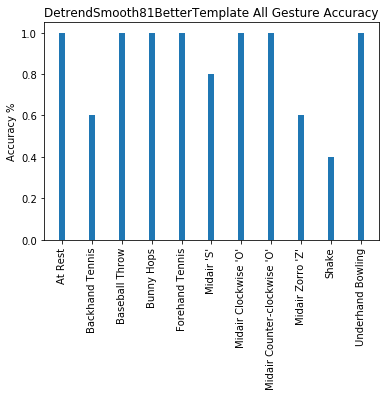

Confusion matrix, without normalization


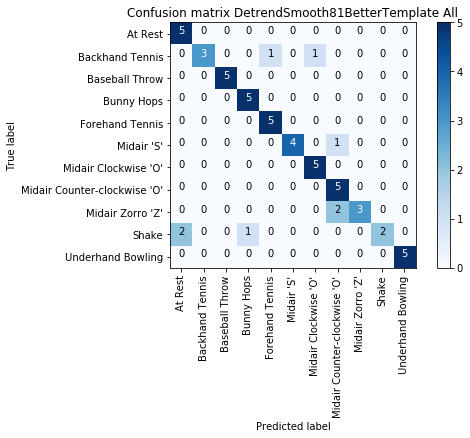

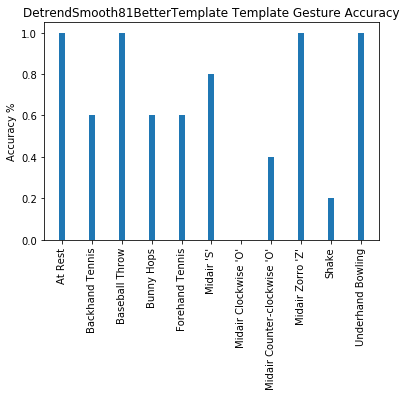

Confusion matrix, without normalization


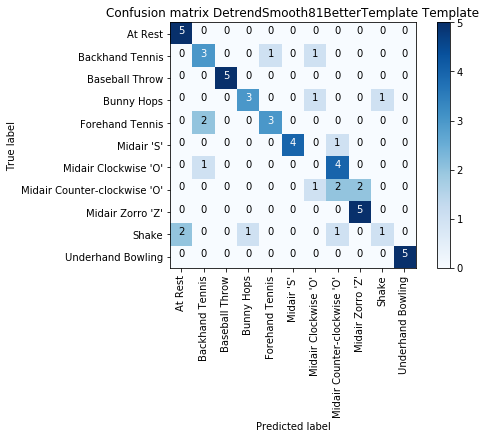

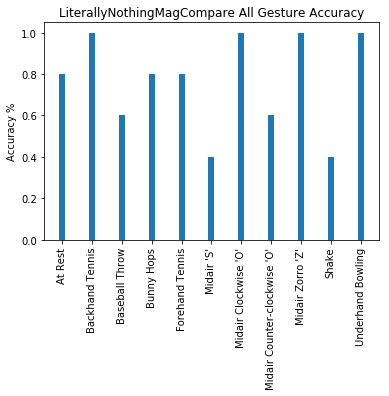

Confusion matrix, without normalization


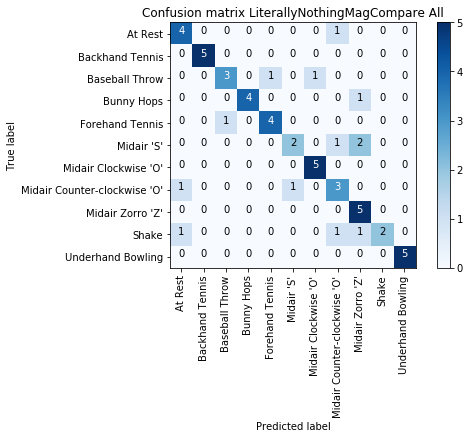

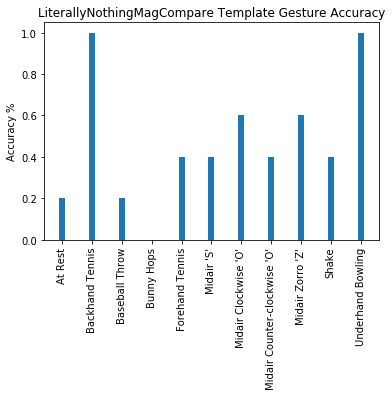

Confusion matrix, without normalization


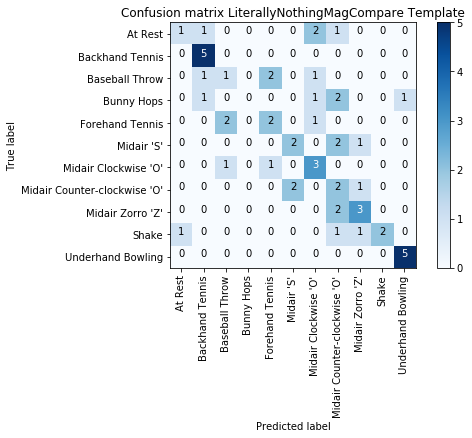

In [210]:
#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html
jonDataHarderConfuse = "./AlgorithmConfusionJonDataHarder"
confFiles = listdir(jonDataHarderConfuse)

for confFile in confFiles:
    fileNoExt = os.path.splitext(confFile)[0]
    confInfo = fileNoExt.split("_")
    
    correctMap = dict()
    true, pred = np.loadtxt(jonDataHarderConfuse +  "/" + confFile, dtype='U30', delimiter=", ")
    labels = []
    for gestureName in true:
        if not gestureName in labels:
            labels.append(gestureName)
            correctMap[gestureName] = 0
            
    for i in range(len(true)):
        if true[i] == pred[i]:
            correctMap[true[i]] += 1
            
    for gesture in correctMap:
        correctMap[gesture] /= len(true) / len(labels)
        
    #https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
    resPltAcc = plt.bar(range(len(correctMap)), list(correctMap.values()), .2)
    plt.ylabel("Accuracy %")
    plt.title(confInfo[0] + " " + confInfo[1] + " Gesture Accuracy")
    plt.xticks(range(len(correctMap)), list(correctMap.keys()), rotation="vertical")
    plt.show()
            
    cm = confusion_matrix(true, pred, labels)
    plt.figure(figsize=(8,6))
    plot_confusion_matrix(cm, classes=labels, title='Confusion matrix ' + confInfo[0] + " " + confInfo[1])
    plt.show()

In [211]:
print(len(kfolds[0][0].accel.x))

266
